# Goal

See if trading cryptos which are shift-correlated BTCUSDT is profitable

So far:
- a few stocks are certainly shift-correlated

- taker's fee wipes out profits for most simple strategies (even with a threshold) for OSMO

To test
- simple taker strategies (take when expected profit > 2*fees)
- take and hold (take, but only change position when expected pnl change > fees)
- market making strategies

pnl attribution:
- how much from fees?
- how much from desired position?
- how much from holding undesired position?
- how much would spread affect pnl?

# Steps

Components of a backtest
- choose a signal (BTC returns, combination of returns, etc)
- use signal --> predicted returns for a specific stock
- take position based on predicted returns, fees, spread, etc. (only take position if predicted returns > cost of getting position)

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [101]:
df = pd.read_csv('./5min_data.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df.head()
print("Daterange:", df.index[0], df.index[-1])

Daterange: 2024-09-01 00:00:00 2024-11-21 19:00:00


In [102]:
# From FindStocks, prepare df
start_train  = datetime(2024, 9, 1)
end_train = datetime(2024, 10, 31)
end_test = datetime(2024, 11, 21, 19)
train_df = df.loc[start_train:end_train].copy()
test_df = df.loc[end_train + timedelta(hours=1):end_test].copy()

def getReturnDf(data):
    data = data.dropna(how='any', axis=1).copy()

    # Get most stock returns
    stocks = [colName.split('_')[0] for colName in data.columns]

    stock_returns = {
        f'{stock}_return': (data[f'{stock}_close'] - data[f'{stock}_close'].shift(1))/data[f'{stock}_close'].shift(1)*100*100
        for stock in stocks
    }

    # Get indicator returns, shifted extra
    indicators = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
    indicator_returns = {
        f'{indicator}_prev_return': ((data[f'{indicator}_close'] - data[f'{indicator}_close'].shift(1))/data[f'{indicator}_close'].shift(1)).shift(1)*100*100
        for indicator in indicators
    }

    return_df = pd.DataFrame({**stock_returns, **indicator_returns})
    return_df = return_df.drop(labels=return_df.index[:2], axis=0)
    return return_df

train_returns = getReturnDf(train_df)
test_returns = getReturnDf(test_df)

                                 OLS Regression Results                                
Dep. Variable:       ETHFIPERP_return   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              70.97
Date:                Sat, 23 Nov 2024   Prob (F-statistic):                    4.45e-17
Time:                        15:57:08   Log-Likelihood:                         -32991.
No. Observations:                6215   AIC:                                  6.598e+04
Df Residuals:                    6214   BIC:                                  6.599e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


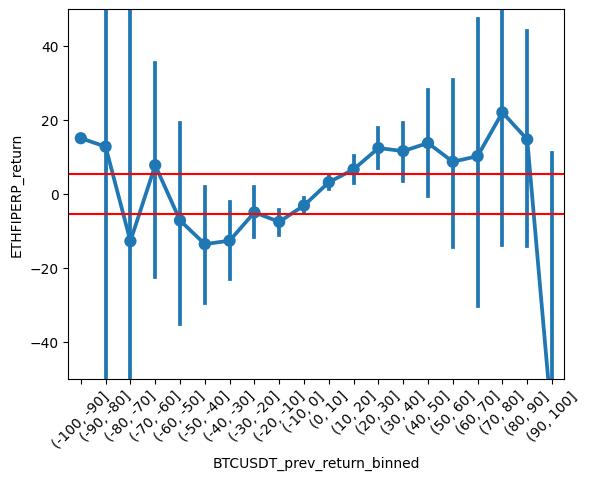

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_33179/4261583227.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'BTCUSDT_prev_return_binned')[f'{stock}_return'].agg(['mean', 'std']).reset_index()


,BTCUSDT_prev_return_binned,mean,std
0,"(-100, -90]",15.071096,NaN
1,"(-90, -80]",12.785453,153.256574
2,"(-80, -70]",-12.793974,121.354585
3,"(-70, -60]",7.761349,72.195221
4,"(-60, -50]",-7.172894,80.769309
5,"(-50, -40]",-13.586129,68.933966
6,"(-40, -30]",-12.655428,63.549625
7,"(-30, -20]",-5.001039,59.048349
8,"(-20, -10]",-7.549107,51.186997
9,"(-10, 0]",-3.133242,41.459192


In [156]:
# Visualizations to find a proper utility function
import statsmodels.api as sm

def findUtility(df, stock):
    X = df['BTCUSDT_prev_return']
    model = sm.OLS(df[f'{stock}_return'], X).fit()
    print(model.summary())

    predictions = model.predict(X)
    df['residuals'] = df[f'{stock}_return'] - predictions
    bins = np.arange(-100, 101, 10)
    df['BTCUSDT_prev_return_binned'] = pd.cut(df['BTCUSDT_prev_return'], bins=bins)
    # display(df['BTCUSDT_prev_return_binned'].value_counts(normalize=True))
    # sns.boxplot(data=df, x='BTCUSDT_prev_return_binned', y='residuals')
    # sns.regplot(data=df, x='BTCUSDT_prev_return', y=f'{stock}_return', scatter_kws = {'alpha': 0.01}, order=3)

    sns.pointplot(data=df, x='BTCUSDT_prev_return_binned', y=f'{stock}_return')
    plt.ylim(bottom=-50, top=50)
    plt.axhline(y=5.5, color='red')
    plt.axhline(y=-5.5, color='red')
    plt.xticks(rotation=45)
    plt.show()

    bin_stats = df.groupby(f'BTCUSDT_prev_return_binned')[f'{stock}_return'].agg(['mean', 'std']).reset_index()
    display(bin_stats)

findUtility(test_returns, 'ETHFIPERP')

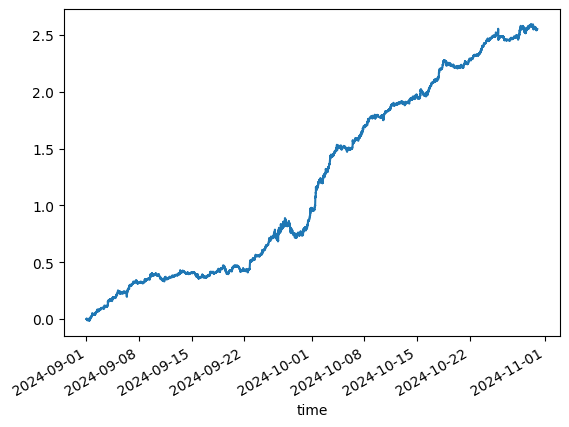

In [153]:
# Backtest
class Backtest:
    def __init__(self, data, x, y):
        self.df = data
        self.x = x # usually BTC prevReturn
        self.y = y # usually new stock returns
        self.fee = 0.0009

    """
    predictionFunction should take in
        1) prevBTCUSDT return
        2) current x stock position
    and output
        1) new current stock position

    basic logic
        1) prev BTCUSDT return --> tells us to go long or short
        2) if already long or signal not strong enough --> don't change position
        3) effectively, we will always be at position 1, or at position -1
    """
    def calculatePositions(self, predictionFunction):
        self.df['position'] = 0

        for i in range(1, len(self.df.index)):
            btc_return = self.df.at[self.df.index[i], self.x] # bitcoin return
            prev_position = self.df.at[self.df.index[i-1], 'position'] # PREV position

            self.df.loc[self.df.index[i], 'position'] = predictionFunction(btc_return, prev_position)
    
    def graph_pnl(self):
        self.df['pnl'] = self.df['position'] * self.df[self.y].shift(-1)/100/100 # convert back from bps --> decimal
        self.df['fees'] = abs(self.df['position'] - self.df['position'].shift(1))*self.fee
        self.df['cumpnl'] = (self.df['pnl'] - self.df['fees']).cumsum()

        self.df['cumpnl'].plot()

def significantThreshold(btc_prev_return, x_position):
    significant = abs(btc_prev_return) > 15
    
    if not significant: return x_position # don't change position if insignificant
    if significant: return np.sign(btc_prev_return)

def naive(btc_prev_return, x_position):
    return np.sign(btc_prev_return)

def linear(btc_prev_return, x_position):
    pos = btc_prev_return/100
    if abs(pos) > 1: return np.sign(pos)
    return pos

def long(btc_prev_return, x_position):
    return 1

b = Backtest(train_returns, x='BTCUSDT_return', y='SHIB1000PERP_return')
b.calculatePositions(predictionFunction = significantThreshold)
b.graph_pnl()

In [65]:
b.df[['BTCUSDT_prev_return', 'OSMOUSDT_return', 'predicted_returns', 'position', 'pnl', 'cumpnl']].head(30)

,BTCUSDT_prev_return,OSMOUSDT_return,predicted_returns,position,pnl,cumpnl
time,,,,,,
2024-09-01 00:10:00,0.000496,0.000512,0.000496,-0.000951,7.290136e-07,NaN
2024-09-01 00:15:00,0.000464,-0.000767,0.000464,0.000734,0.000000e+00,-9.266533e-07
2024-09-01 00:20:00,-0.000951,0.000000,-0.000951,0.000862,0.000000e+00,-9.969005e-07
2024-09-01 00:25:00,0.000734,0.000000,0.000734,0.000767,-3.925267e-07,-1.441523e-06
2024-09-01 00:30:00,0.000862,-0.000512,0.000862,0.000000,0.000000e+00,-1.863479e-06
2024-09-01 00:35:00,0.000767,0.001024,0.000767,0.000000,0.000000e+00,-1.863479e-06
2024-09-01 00:40:00,-0.000504,0.000000,-0.000504,-0.001545,-0.000000e+00,-2.713259e-06
2024-09-01 00:45:00,-0.000531,0.000000,-0.000531,0.000000,0.000000e+00,-3.563038e-06
2024-09-01 00:50:00,-0.001545,0.000000,-0.001545,0.000000,0.000000e+00,-3.563038e-06
